In [43]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ohlc as candlestick
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


# Load & prep data

In [23]:
start_dt = datetime.datetime(2017, 3, 1)
end_dt = datetime.date.today()

In [37]:
smbl_apple = pdr.DataReader("AAPL", "google", start_dt, end_dt)
smbl_intc = pdr.DataReader("INTC", "google", start_dt, end_dt)
smbl_mcsft = pdr.DataReader("MSFT", "google", start_dt, end_dt)

In [25]:
smbl_apple.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-03-01,137.89,140.15,137.60,139.79,36414585
2017-03-02,140.00,140.28,138.76,138.96,26210984
2017-03-03,138.78,139.83,138.59,139.78,21571121
2017-03-06,139.36,139.77,138.60,139.34,21750044
2017-03-07,139.06,139.98,138.79,139.52,17446297


# Visualizing

## Charting one symbol

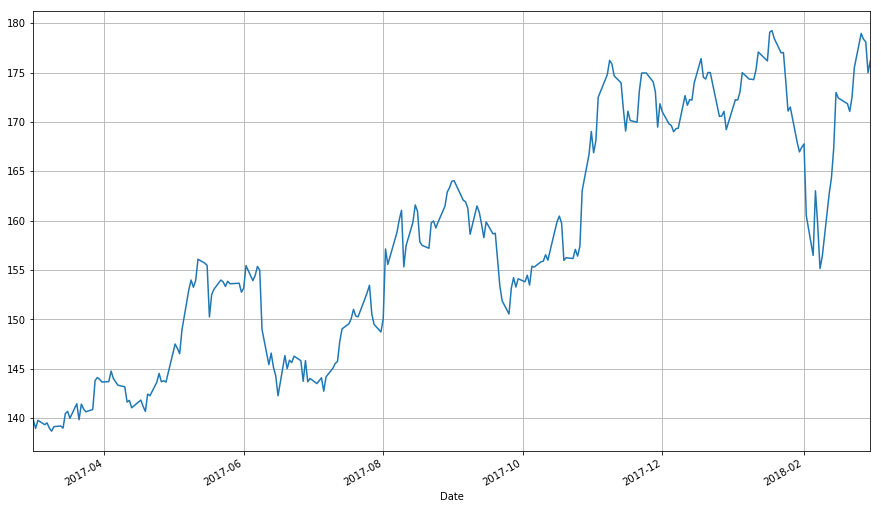

In [26]:
smbl_apple['Close'].plot(grid=True)

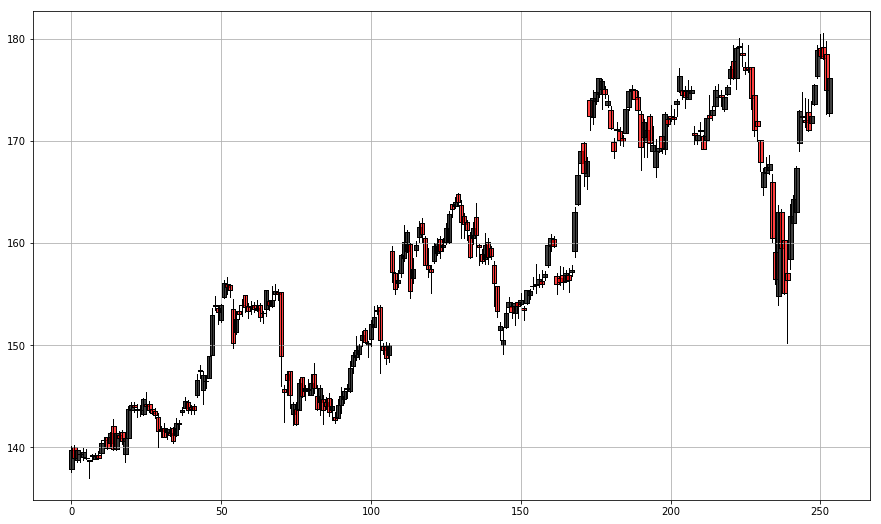

In [36]:
fig, ax = plt.subplots()
candlestick(ax, smbl_apple['Open'], smbl_apple['High'], smbl_apple['Low'], smbl_apple['Close'], width=1.5)
ax.grid()
plt.show()

## Charting multiple symbols

In [38]:
port = pd.DataFrame({
    "AAPL": smbl_apple['Close'],
    "INTC": smbl_intc['Close'],
    "MSFT": smbl_mcsft['Close']
})
port.head()

,AAPL,INTC,MSFT
Date,,,
2017-03-01,139.79,35.93,64.94
2017-03-02,138.96,35.91,64.01
2017-03-03,139.78,35.90,64.25
2017-03-06,139.34,35.57,64.27
2017-03-07,139.52,35.80,64.40


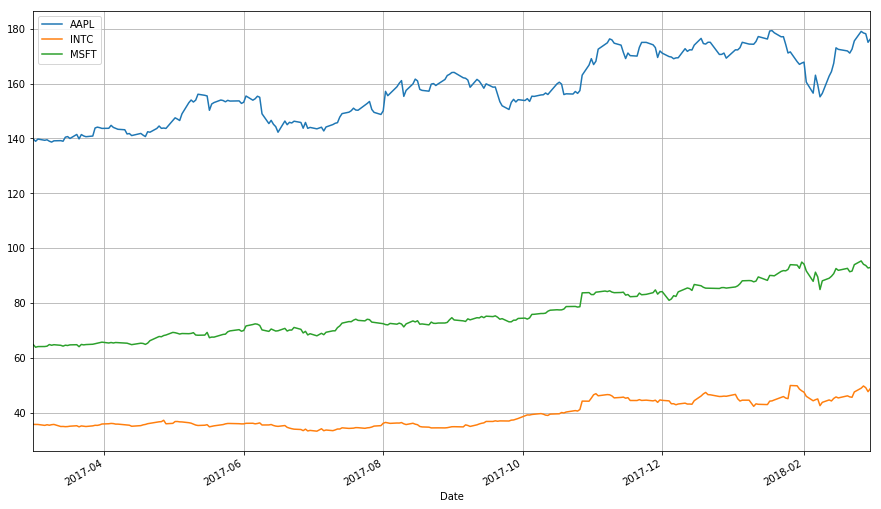

In [39]:
port.plot(grid=True)

Given successful stock trades tend to rely more upon volatility than absolute price, it would be beneficial to see these at split scales in order to more directly compare the volatility of the stocks. Let's move the MSFT and INTC Y scale to another level so that we can visualize the trends closer together.

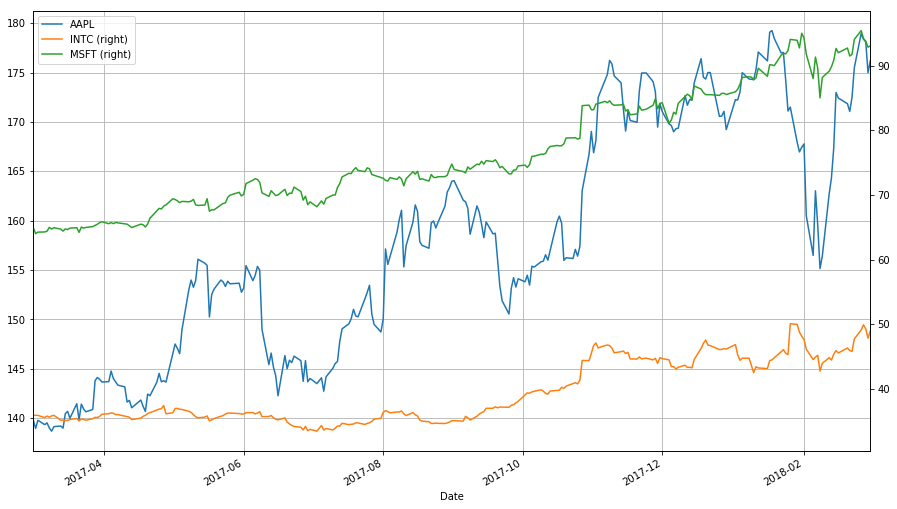

In [40]:
port.plot(grid=True, secondary_y=["INTC", "MSFT"])

While more useful than visualizing the absolute prices, this is still not the best option. It might be more useful to visualize the return on the stock based upon having purchased it at the beginning of the time period.

$$return_{t,0} = \frac{price_t}{price_0}$$

In [41]:
port_return = port.apply(lambda x: x / x[0])
port_return.head()

,AAPL,INTC,MSFT
Date,,,
2017-03-01,1.000000,1.000000,1.000000
2017-03-02,0.994063,0.999443,0.985679
2017-03-03,0.999928,0.999165,0.989375
2017-03-06,0.996781,0.989981,0.989683
2017-03-07,0.998069,0.996382,0.991685


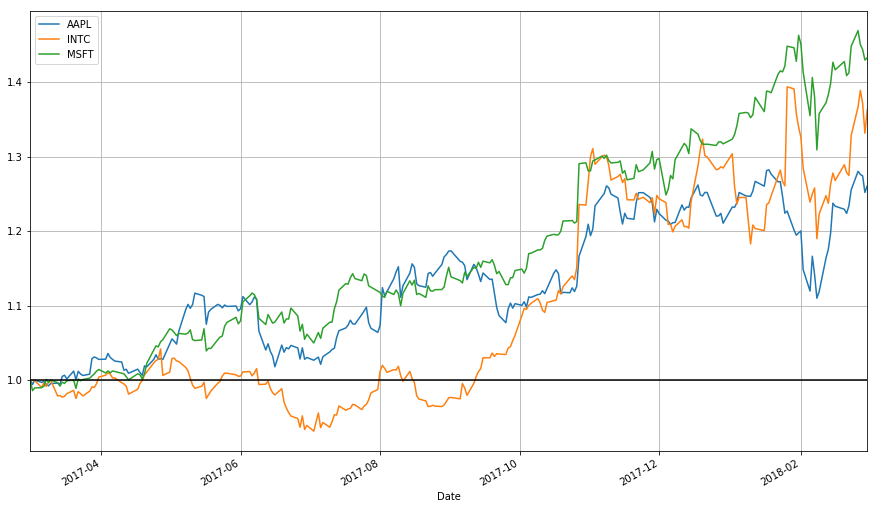

In [42]:
port_return.plot(grid=True).axhline(y=1, color='black')

Here we see the multiplier of value had these stocks been purchased at the beginning of the time period we are viewing. Also worthy of note is that these stocks appear highly correlated in that they generally trend in the same direction to varying degrees.

Another useful view of stocks worthy of examination is growth. This can be achieved by calculating log differences which can be interpreted as percentage change, but without the dependency upon a denominator.

$$change_t = log(price_t) - log(price_{t-1})$$

In [44]:
port_growth = port.apply(lambda x: np.log(x) - np.log(x.shift(1)))
port_growth.head()

,AAPL,INTC,MSFT
Date,,,
2017-03-01,NaN,NaN,NaN
2017-03-02,-0.005955,-0.000557,-0.014424
2017-03-03,0.005884,-0.000279,0.003742
2017-03-06,-0.003153,-0.009235,0.000311
2017-03-07,0.001291,0.006445,0.002021


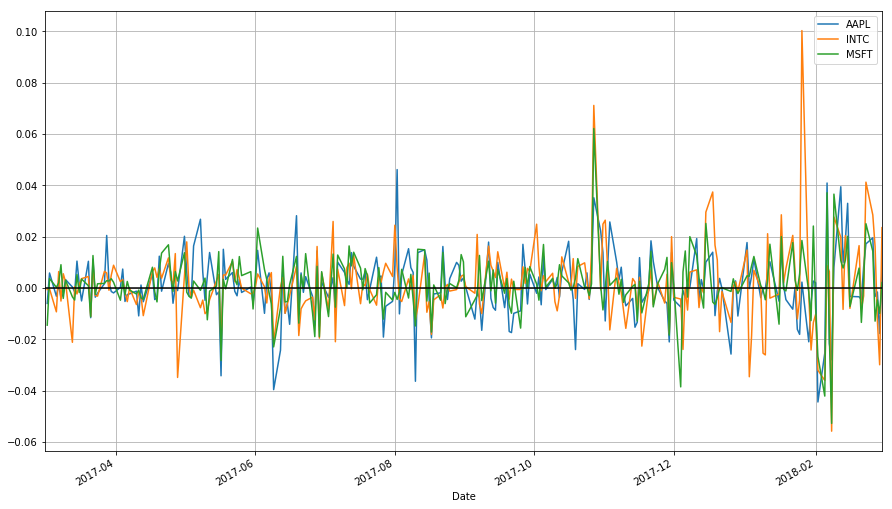

In [45]:
port_growth.plot(grid=True).axhline(y=0, color='black')

Examining the returns is valuable for buying decisions but this sort of change comparison is more often used in advanced modeling methods.

## Moving averages

Moving averages smooth a trend line in order to make it easier to analyze longer term trends apart from noise in the data. **Fast** moving averages have smaller _q_ and are more sensitive to daily fluctuations while **slow** moving averages have larger _q_ and are less sensitive to daily fluctuations..

$$M A^q_t = \frac{1}{q} \sum^{q-1}_{i=0} x_{t - i}$$

Here we'll add moving averages for 21 and 60 days.

In [57]:
smbl_apple['21d'] = np.round(smbl_apple['Close'].rolling(window=21, center=False).mean(), 2)
smbl_apple['60d'] = np.round(smbl_apple['Close'].rolling(window=60, center=False).mean(), 2)

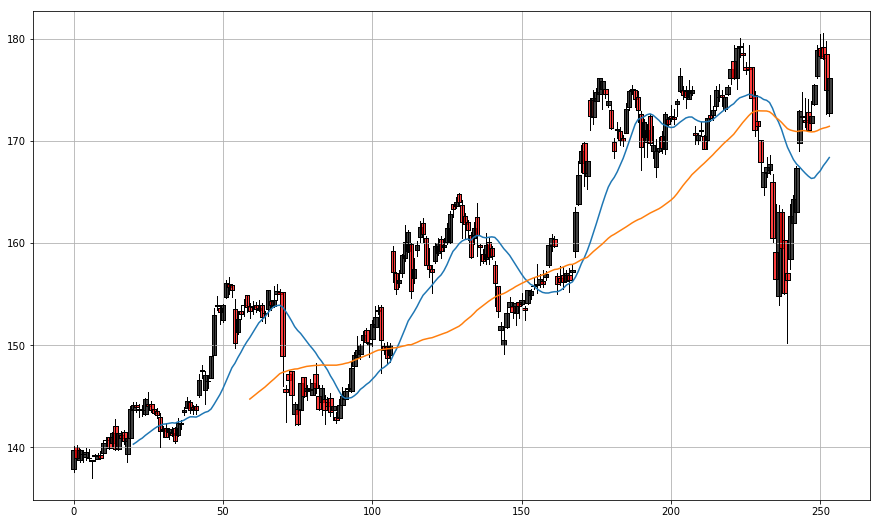

In [58]:
fig, ax = plt.subplots()
candlestick(ax, smbl_apple['Open'], smbl_apple['High'], smbl_apple['Low'], smbl_apple['Close'], width=1.5)
ax.plot(smbl_apple['21d'].values)
ax.plot(smbl_apple['60d'].values)
ax.grid()
plt.show()

# Trading strategies

## Moving average crossover

This stategy will use two moving averages, one fast and one slow, and actions are decided based upon two criteria:

1. Trade when the fast moving average crosses the slow moving average, long when the fast moving average crosses over and short when the fast moving average crosses under
2. Exit when the fast moving average crosses the slow moving average again

Before executing the strategy, we want to test it against our historical data with the 21 day and 60 day averages.

In [59]:
smbl_apple['21d-60d'] = smbl_apple['21d'] - smbl_apple['60d']
smbl_apple.tail()

,Open,High,Low,Close,Volume,21d,60d,21d-60d
Date,,,,,,,,
2018-02-26,176.35,179.39,176.21,178.97,38162174,166.79,171.03,-4.24
2018-02-27,179.10,180.48,178.16,178.39,38928125,167.11,171.18,-4.07
2018-02-28,179.26,180.62,178.05,178.12,37782138,167.60,171.28,-3.68
2018-03-01,178.54,179.78,172.66,175.00,48801970,167.98,171.35,-3.37
2018-03-02,172.80,176.30,172.45,176.21,38453950,168.40,171.46,-3.06


In [60]:
smbl_apple['Regime'] = np.where(smbl_apple['21d-60d'] > 0, 1, 0)
smbl_apple['Regime'] = np.where(smbl_apple['21d-60d'] < 0, -1, smbl_apple['Regime'])

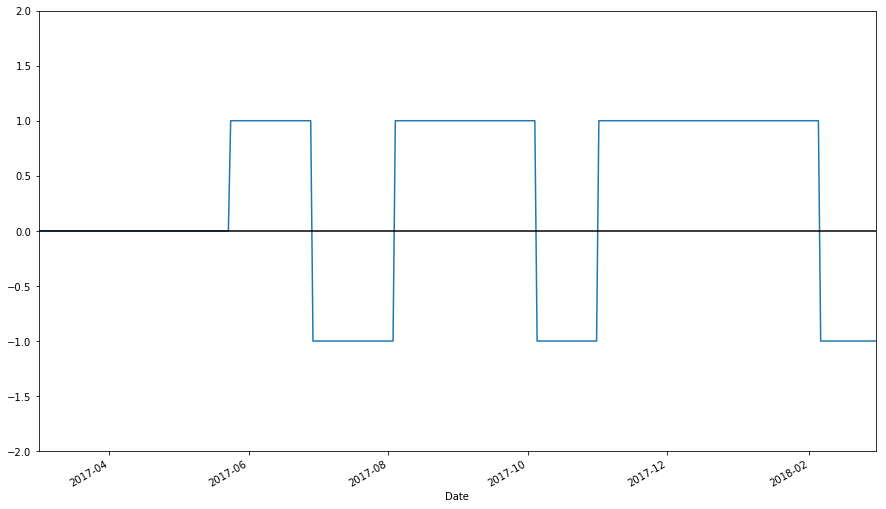

In [61]:
smbl_apple["Regime"].plot(ylim=(-2, 2)).axhline(y=0, color='black')

In [63]:
regime_original = smbl_apple.ix[-1, "Regime"]

smbl_apple.ix[-1, "Regime"] = 0
# use sign as trade signal
smbl_apple['Signal'] = np.sign(smbl_apple['Regime'] - smbl_apple['Regime'].shift(1))

smbl_apple.ix[-1, "Regime"] = regime_original
smbl_apple.tail()

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Volume,21d,60d,21d-60d,Regime,Signal
Date,,,,,,,,,,
2018-02-26,176.35,179.39,176.21,178.97,38162174,166.79,171.03,-4.24,-1.0,0.0
2018-02-27,179.10,180.48,178.16,178.39,38928125,167.11,171.18,-4.07,-1.0,0.0
2018-02-28,179.26,180.62,178.05,178.12,37782138,167.60,171.28,-3.68,-1.0,0.0
2018-03-01,178.54,179.78,172.66,175.00,48801970,167.98,171.35,-3.37,-1.0,0.0
2018-03-02,172.80,176.30,172.45,176.21,38453950,168.40,171.46,-3.06,-1.0,1.0


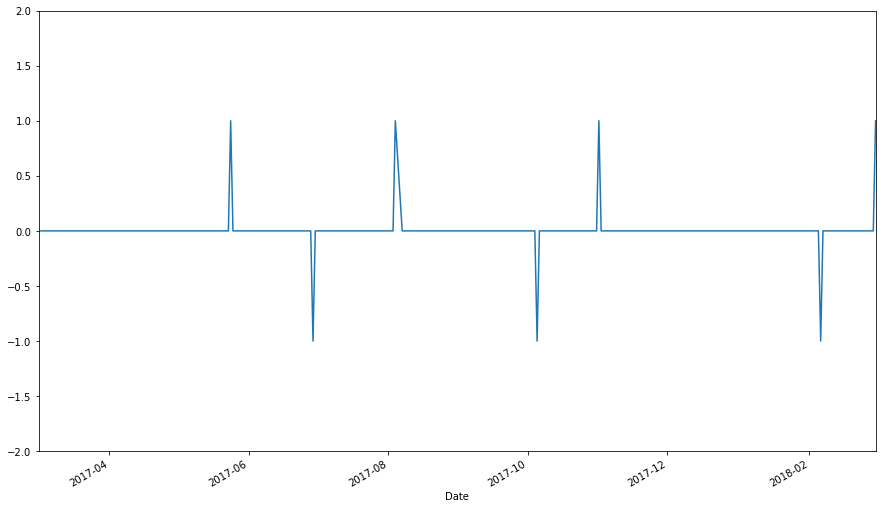

In [64]:
smbl_apple["Signal"].plot(ylim=(-2, 2))

In [67]:
# look at prices at every buy and sell
smbl_apple.loc[smbl_apple['Signal'] == 1, "Close"]

Date
2017-05-24    153.34
2017-08-04    156.39
2017-11-01    166.89
2018-03-02    176.21
Name: Close, dtype: float64

In [68]:
smbl_apple.loc[smbl_apple['Signal'] == -1, "Close"]

Date
2017-06-29    143.68
2017-10-05    155.39
2018-02-06    163.03
Name: Close, dtype: float64

In [69]:
# get a list of trade dates with price
appl_signals = pd.concat([
        pd.DataFrame({"Price": smbl_apple.loc[smbl_apple["Signal"] == 1, "Close"],
                     "Regime": smbl_apple.loc[smbl_apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": smbl_apple.loc[smbl_apple["Signal"] == -1, "Close"],
                     "Regime": smbl_apple.loc[smbl_apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
appl_signals.sort_index(inplace = True)
appl_signals

,Price,Regime,Signal
Date,,,
2017-05-24,153.34,1.0,Buy
2017-06-29,143.68,-1.0,Sell
2017-08-04,156.39,1.0,Buy
2017-10-05,155.39,-1.0,Sell
2017-11-01,166.89,1.0,Buy
2018-02-06,163.03,-1.0,Sell
2018-03-02,176.21,-1.0,Buy


In [73]:
# get a list of trade dates with profitability
price = appl_signals.loc[(appl_signals["Signal"] == "Buy") & (appl_signals["Regime"] == 1), "Price"]
profit = pd.Series(appl_signals["Price"] - appl_signals["Price"].shift(1)).loc[
            appl_signals.loc[(appl_signals["Signal"].shift(1) == "Buy") & (appl_signals["Regime"].shift(1) == 1)].index
        ].tolist()
end_date = appl_signals["Price"].loc[
            appl_signals.loc[(appl_signals["Signal"].shift(1) == "Buy") & (appl_signals["Regime"].shift(1) == 1)].index
        ].index

long_profits = pd.DataFrame({
        "Price": price,
        "Profit": profit,
        "End Date": end_date
    })

long_profits

,End Date,Price,Profit
Date,,,
2017-05-24,2017-06-29,153.34,-9.66
2017-08-04,2017-10-05,156.39,-1.00
2017-11-01,2018-02-06,166.89,-3.86


We can see here that over the period of time we are examining, this trading strategy would perform quite poorly. It would be worthwhile to reproduce this strategy over a greater period of time. 

_Note we have not yet made any considerations for splits or dividends._

## Benchmarking against the SPY

In [74]:
smbl_spy = pdr.DataReader("SPY", "google", start_dt, end_dt)

In [75]:
smbl_spy.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-03-01,238.39,240.32,238.37,239.78,149158170
2017-03-02,239.56,239.57,238.21,238.27,70245978
2017-03-03,238.17,238.61,237.73,238.42,81974300
2017-03-06,237.50,238.12,237.01,237.71,55391533
2017-03-07,237.36,237.77,236.76,237.00,65103737


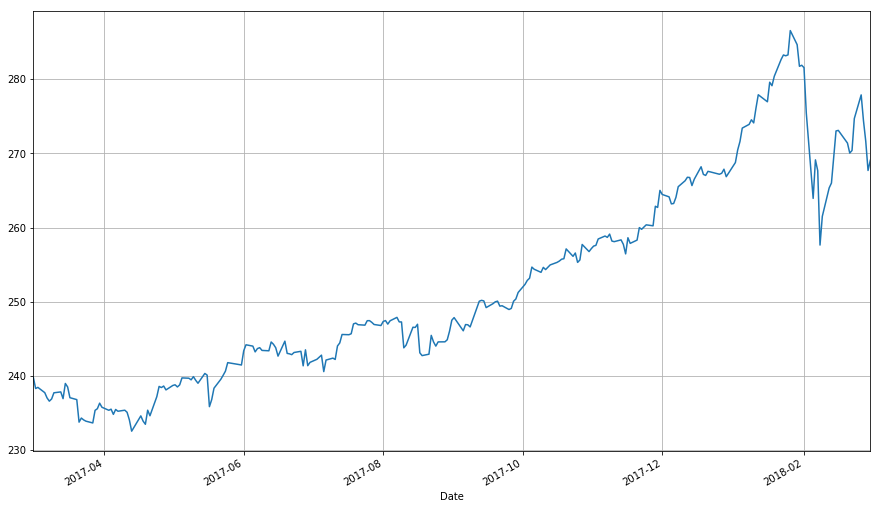

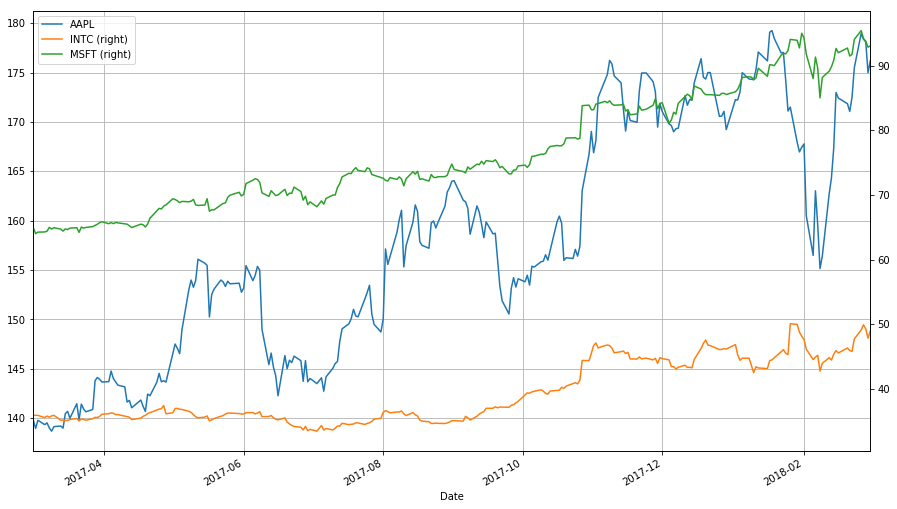

In [77]:
smbl_spy["Close"].plot(grid=True)
port.plot(grid=True, secondary_y=["INTC", "MSFT"])